# Universidade Federal do Rio Grande do Norte


## Programa de Pós-Graduação em Engenharia Elétrica e de Computação
## EEC1509 - Aprendizagem de Máquina


# Group

## João Lucas Correia Barbosa de Farias

## Júlio Freire Peixoto Gomes


# Project 1 - Red Wine Quality Classification


## About the Project
This project is divided in 8 files including this one, where each one represents one step in the process of deploying a machine learning algorithm. In this case, we choose a Decision Tree algorithm as Classifier due to its simplicity and because it is the algorithm we saw in class. However, other classifiers may perform a better fit.

The dataset has some characteristics about red wines and their quality based on that information, so our mission is to predict the quality of any red wine using the same information we used to train our model.


### The details about the dataset are shown below.

For more information, read [Cortez et al., 2009].

### Input variables (based on physicochemical tests):


1. fixed acidity

2. volatile acidity

3. citric acid

4. residual sugar

5. chlorides

6. free sulfur dioxide

7. total sulfur dioxide

8. density

9. pH

10. sulphates

11. alcohol

Output variable (based on sensory data):

12. quality (score between 0 and 10)

## The dataset was taken from Kaggle:
https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

# 1.0 Install and Load Libraries


In [ ]:
# install wandb
!pip install wandb

In [ ]:
import wandb
import logging
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.metrics import geometric_mean_score

# 2.0 Login to Weights & Biases

In [ ]:
# login to wandb
!wandb login --relogin

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# 3.0 Data Preparation

In [ ]:
# ratio used to split train and test data
val_size = 0.30

# seed used to reproduce purposes
seed = 13

# reference (column) to stratify the data
stratify = 'quality'

# name of the input artifact
artifact_input_name = "red_wine_quality/train.csv:latest"

# type of the artifact
artifact_type = "Train"

In [ ]:
# initiate wandb project
run = wandb.init(project="red_wine_quality", job_type="train")

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


In [ ]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

logger.info("Downloading and reading artifact...")
artifact = run.use_artifact(artifact_input_name)
artifact_path = artifact.file()
df_train = pd.read_csv(artifact_path)

# we will split the train set into training and validation sets
logger.info("Spliting data into training and validation sets...")
x_train, x_val, y_train, y_val = train_test_split(df_train.drop(labels=stratify,axis=1),
                                                  df_train[stratify],
                                                  test_size=val_size,
                                                  random_state=seed,
                                                  shuffle=True,
                                                  stratify=df_train[stratify])

29-05-2022 04:14:49 Downloading and reading artifact...
29-05-2022 04:14:50 Spliting data into training and validation sets...


In [ ]:
logger.info("x train: {}".format(x_train.shape))
logger.info("y train: {}".format(y_train.shape))
logger.info("x val: {}".format(x_val.shape))
logger.info("y val: {}".format(y_val.shape))

29-05-2022 04:14:51 x train: (665, 11)
29-05-2022 04:14:51 y train: (665,)
29-05-2022 04:14:51 x val: (286, 11)
29-05-2022 04:14:51 y val: (286,)


In [ ]:
x_train.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
265,8.4,0.37,0.43,2.3,0.063,12.0,19.0,0.99550,3.17,0.81,11.2
28,7.1,0.47,0.00,2.2,0.067,7.0,14.0,0.99517,3.40,0.58,10.9
896,10.2,0.33,0.46,1.9,0.081,6.0,9.0,0.99628,3.10,0.48,10.4
102,9.6,0.88,0.28,2.4,0.086,30.0,147.0,0.99790,3.24,0.53,9.4
628,6.0,0.51,0.00,2.1,0.064,40.0,54.0,0.99500,3.54,0.93,10.7


In [ ]:
x_train.isnull().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
ph                      0
sulphates               0
alcohol                 0
dtype: int64

### 3.1 Outlier Removal

In [ ]:
# we will only remove outliers
x_aux = x_train.select_dtypes("float").copy()
x_aux.head()

In [ ]:
# identifying outliers in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x_aux)
mask = outlier != -1

In [ ]:
logger.info("x_train shape [original]: {}".format(x_train.shape))
logger.info("x_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))

29-05-2022 04:14:56 x_train shape [original]: (665, 11)
29-05-2022 04:14:56 x_train shape [outlier removal]: (653, 11)


In [ ]:
# removing outliers from x_train and y_train
logger.info("Outlier Removal")
x_train = x_train.loc[mask,:].copy()
y_train = y_train[mask].copy()

29-05-2022 04:14:56 Outlier Removal


### 3.2 Encoding Target Variable

In [ ]:
logger.info("Encoding Target Variable...")
# using a categorical encoding for the target variable
le = LabelEncoder()

# applying fit and transform to y_train
y_train = le.fit_transform(y_train)

# only applying transform to y_val
y_val = le.transform(y_val)

logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

29-05-2022 04:14:59 Encoding Target Variable...
29-05-2022 04:14:59 Classes [0, 1]: ['bad' 'good']


# 4.0 Pipeline

## 4.1 Feature Selector

The input to the pipeline is the x_train set. We will create a class whose sole goal is to return the object itself to be the beginning of the pipeline.

In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # constructor of the classs
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.feature_names]

In [ ]:
# only numeric datatypes
x_train_numerical_types_list = x_train.select_dtypes("float64").columns.to_list()
fs = FeatureSelector(x_train_numerical_types_list)
df = fs.fit_transform(x_train)
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
265,8.4,0.37,0.43,2.3,0.063,12.0,19.0,0.99550,3.17,0.81,11.2
28,7.1,0.47,0.00,2.2,0.067,7.0,14.0,0.99517,3.40,0.58,10.9
896,10.2,0.33,0.46,1.9,0.081,6.0,9.0,0.99628,3.10,0.48,10.4
102,9.6,0.88,0.28,2.4,0.086,30.0,147.0,0.99790,3.24,0.53,9.4
628,6.0,0.51,0.00,2.1,0.064,40.0,54.0,0.99500,3.54,0.93,10.7


## 4.2 Processing Numerical Features

In [ ]:
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # model 0: minmax
    # model 1: standard
    # model 2: no scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # fit function is responsible for learning statistical data about features
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # function to retrieve columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # transforming numerical features
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

In [ ]:
# testing functions
x_train_numerical_types_list = x_train.select_dtypes("float64").columns.to_list()
fs = FeatureSelector(x_train_numerical_types_list)
df = fs.fit_transform(x_train)
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
265,8.4,0.37,0.43,2.3,0.063,12.0,19.0,0.99550,3.17,0.81,11.2
28,7.1,0.47,0.00,2.2,0.067,7.0,14.0,0.99517,3.40,0.58,10.9
896,10.2,0.33,0.46,1.9,0.081,6.0,9.0,0.99628,3.10,0.48,10.4
102,9.6,0.88,0.28,2.4,0.086,30.0,147.0,0.99790,3.24,0.53,9.4
628,6.0,0.51,0.00,2.1,0.064,40.0,54.0,0.99500,3.54,0.93,10.7


In [ ]:
# testing functions
nt = NumericalTransformer(model=0)
df_num = nt.fit_transform(df)
df_num

array([[0.34862385, 0.17948718, 0.43      , ..., 0.33858268, 0.28742515,
        0.5       ],
       [0.2293578 , 0.26495726, 0.        , ..., 0.51968504, 0.1497006 ,
        0.44642857],
       [0.51376147, 0.14529915, 0.46      , ..., 0.28346457, 0.08982036,
        0.35714286],
       ...,
       [0.21100917, 0.27350427, 0.2       , ..., 0.51181102, 0.05988024,
        0.11607143],
       [0.27522936, 0.2991453 , 0.24      , ..., 0.57480315, 0.19760479,
        0.21428571],
       [0.28440367, 0.5042735 , 0.27      , ..., 0.39370079, 0.07185629,
        0.16071429]])

In [ ]:
# returning columns name
nt.get_feature_names_out()

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'ph',
 'sulphates',
 'alcohol']

## 4.3 Pipeline Creation

In [ ]:
# model = 0 (min-max), 1 (z-score), 2 (no scaling)
numerical_model = 0

# numerical features to pass down the numerical pipeline
numerical_features = x_train.select_dtypes("float64").columns.to_list()

# defining the steps in the numerical pipeline
numerical_pipeline = Pipeline(steps=[('num_selector', FeatureSelector(numerical_features)),
                                     ('imputer_num', SimpleImputer(strategy="median")),
                                     ('num_transformer', NumericalTransformer(numerical_model, 
                                                                              colnames=numerical_features))])

# combining numerical and categorical pieplines into one full big pipeline horizontally
full_pipeline_preprocessing = FeatureUnion(transformer_list=[
                                                             ('num_pipeline', numerical_pipeline)]
                                           )

In [ ]:
# testing pipeline
new_data = full_pipeline_preprocessing.fit_transform(x_train)
# num_names is a list
num_names = full_pipeline_preprocessing.get_params()["num_pipeline"][2].get_feature_names_out()
df = pd.DataFrame(new_data,columns = num_names)

df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
0,0.348624,0.179487,0.43,0.107692,0.043706,0.183673,0.081761,0.415138,0.338583,0.287425,0.500000
1,0.229358,0.264957,0.00,0.100000,0.050699,0.081633,0.050314,0.389908,0.519685,0.149701,0.446429
2,0.513761,0.145299,0.46,0.076923,0.075175,0.061224,0.018868,0.474771,0.283465,0.089820,0.357143
3,0.458716,0.615385,0.28,0.115385,0.083916,0.551020,0.886792,0.598624,0.393701,0.119760,0.178571
4,0.128440,0.299145,0.00,0.092308,0.045455,0.755102,0.301887,0.376911,0.629921,0.359281,0.410714


# 5.0 Training

In [ ]:
# full pipeline + decisison tree classifier
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier", DecisionTreeClassifier())
                         ]
                )

# training the model
logger.info("Training...")
pipe.fit(x_train, y_train)

# predict validation set
logger.info("Infering...")
predict = pipe.predict(x_val)

# analyzing results with evaluation metrics
logger.info(f"Analyzing results...\n")

acc = accuracy_score(y_val, predict)
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

29-05-2022 04:15:19 Training...
29-05-2022 04:15:19 Infering...
29-05-2022 04:15:19 Analyzing results...

29-05-2022 04:15:19 Accuracy: 0.8566433566433567
29-05-2022 04:15:19 Precision: 0.47619047619047616
29-05-2022 04:15:19 Recall: 0.5128205128205128
29-05-2022 04:15:19 F1: 0.49382716049382713


In [ ]:
logger.info("Analysis of Validation Set and Prediction")
logger.info(f"Minimum value of validation set: {y_val.min()}")
logger.info(f"Maximum value of validation set: {y_val.max()}")
logger.info(f"Mean value of validation set: {y_val.mean()}")
logger.info(f"STD value of validation set: {y_val.std()}")
logger.info(f"Minimum value of prediction: {predict.min()}")
logger.info(f"Maximum value of prediction: {predict.max()}")
logger.info(f"Mean value of prediction: {predict.mean()}")
logger.info(f"STD value of prediction: {predict.std()}")

29-05-2022 04:15:20 Analysis of Validation Set and Prediction
29-05-2022 04:15:20 Minimum value of validation set: 0
29-05-2022 04:15:20 Maximum value of validation set: 1
29-05-2022 04:15:20 Mean value of validation set: 0.13636363636363635
29-05-2022 04:15:20 STD value of validation set: 0.34317429251230686
29-05-2022 04:15:20 Minimum value of prediction: 0
29-05-2022 04:15:20 Maximum value of prediction: 1
29-05-2022 04:15:20 Mean value of prediction: 0.14685314685314685
29-05-2022 04:15:20 STD value of prediction: 0.3539594611145109


In [ ]:
run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [ ]:
# predict bias
logger.info("Infering Bias")
predict_bias = pipe.predict(x_train)

# Evaluation Metrics
logger.info("Bias Evaluation metrics")
acc = accuracy_score(y_train, predict_bias)
fbeta = fbeta_score(y_train, predict_bias, average='weighted', beta=1, zero_division=1)
precision = precision_score(y_train, predict_bias, average='weighted', zero_division=1)
recall = recall_score(y_train, predict_bias, average='weighted', zero_division=1)

logger.info("Bias Accuracy: {}".format(acc))
logger.info("Bias Precision: {}".format(precision))
logger.info("Bias Recall: {}".format(recall))
logger.info("Bias F1: {}".format(fbeta))

29-05-2022 04:15:25 Infering Bias
29-05-2022 04:15:25 Bias Evaluation metrics
29-05-2022 04:15:25 Bias Accuracy: 1.0
29-05-2022 04:15:25 Bias Precision: 1.0
29-05-2022 04:15:25 Bias Recall: 1.0
29-05-2022 04:15:25 Bias F1: 1.0


In [ ]:
# comparing the accuracy, precision, recall with previous ones
print(classification_report(y_val,predict,zero_division=1))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       247
           1       0.48      0.51      0.49        39

    accuracy                           0.86       286
   macro avg       0.70      0.71      0.71       286
weighted avg       0.86      0.86      0.86       286



In [ ]:
# importance of each feature
pipe.get_params()["classifier"].feature_importances_

array([0.07190188, 0.04720093, 0.07529993, 0.07303951, 0.08208876,
       0.02587346, 0.1060561 , 0.07457543, 0.06497327, 0.10598142,
       0.27300931])

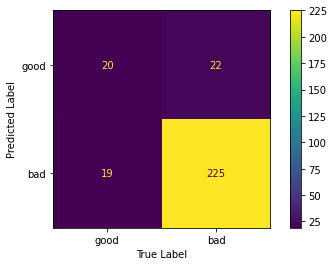

In [ ]:
# confusion matrix y_val and predict
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_val,labels=[1,0]),
                       display_labels=["good","bad"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

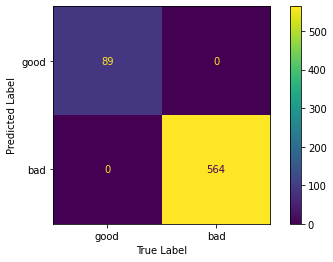

In [ ]:
# confusion matrix y_train and predict_bias
predict_bias = pipe.predict(x_train)
fig_confusion_matrix_bias, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict_bias,y_train,labels=[1,0]),
                       display_labels=["good","bad"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [ ]:
# retrieving numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'ph',
 'sulphates',
 'alcohol']

In [ ]:
all_names = num_names
all_names

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'ph',
 'sulphates',
 'alcohol']

In [ ]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='DT', feature_names=all_names)

wandb: 
wandb: Plotting DT.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        "confusion_matrix": wandb.Image(fig_confusion_matrix_bias)
    }
)

29-05-2022 04:15:39 Uploading figures


In [ ]:
# finishing the run
run.finish()

Acc,0.85664
F1,0.46753
Precision,0.47368
Recall,0.46154


## 5.1 Hyperparameter Tuning

In [ ]:
# global seed
seed = 13

In [ ]:
sweep_config = {
    # try grid or random
    "method": "random",
    "metric": {
        "name": "Accuracy",
        "goal": "maximize"
        },
    "parameters": {
        "criterion": {
            "values": ["gini","entropy"]
            },
        "splitter": {
            "values": ["random","best"]
        },
        "model": {
            "values": [0,1,2]
        },
        "random_state": {
            "values": [seed]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="red_wine_quality")

Create sweep with ID: 720gp8a4
Sweep URL: https://wandb.ai/ppgeec-ml-jj/red_wine_quality/sweeps/720gp8a4


In [ ]:
def train():
    with wandb.init() as run:

        # The full pipeline 
        pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                                    ("classifier",DecisionTreeClassifier())
                                    ]
                        )

        # update the parameters of the pipeline that we would like to tuning
        pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": run.config.model})
        pipe.set_params(**{"classifier__criterion": run.config.criterion})
        pipe.set_params(**{"classifier__splitter": run.config.splitter})
        pipe.set_params(**{"classifier__random_state": run.config.random_state})

        # training
        logger.info("Training")
        pipe.fit(x_train, y_train)

        # predict
        logger.info("Infering")
        predict = pipe.predict(x_val)

        # Evaluation Metrics
        logger.info("Evaluation metrics")
        fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
        precision = precision_score(y_val, predict, zero_division=1)
        recall = recall_score(y_val, predict, zero_division=1)
        acc = accuracy_score(y_val, predict)
        gmean = geometric_mean_score(y_val,predict)

        logger.info("Accuracy: {}".format(acc))
        logger.info("Precision: {}".format(precision))
        logger.info("Recall: {}".format(recall))
        logger.info("F1: {}".format(fbeta))
        logger.info("G-Mean: {}".format(gmean))

        run.summary["Accuracy"] = acc
        run.summary["Precision"] = precision
        run.summary["Recall"] = recall
        run.summary["F1"] = fbeta
        run.summary["G-Mean"] = gmean

In [ ]:
wandb.agent(sweep_id, train, count=12)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: dsavx6z1 with config:
wandb: 	criterion: entropy
wandb: 	model: 0
wandb: 	random_state: 13
wandb: 	splitter: random


29-05-2022 04:15:56 Training
29-05-2022 04:15:56 Infering
29-05-2022 04:15:56 Evaluation metrics
29-05-2022 04:15:56 Accuracy: 0.8496503496503497
29-05-2022 04:15:56 Precision: 0.43333333333333335
29-05-2022 04:15:56 Recall: 0.3333333333333333
29-05-2022 04:15:56 F1: 0.37681159420289856
29-05-2022 04:15:56 G-Mean: 0.5571277797982631


Accuracy,0.84965
F1,0.37681
G-Mean,0.55713
Precision,0.43333
Recall,0.33333


wandb: Agent Starting Run: fdozcd0f with config:
wandb: 	criterion: gini
wandb: 	model: 2
wandb: 	random_state: 13
wandb: 	splitter: best


29-05-2022 04:16:09 Training
29-05-2022 04:16:09 Infering
29-05-2022 04:16:09 Evaluation metrics
29-05-2022 04:16:09 Accuracy: 0.8426573426573427
29-05-2022 04:16:09 Precision: 0.42105263157894735
29-05-2022 04:16:09 Recall: 0.41025641025641024
29-05-2022 04:16:09 F1: 0.4155844155844156
29-05-2022 04:16:09 G-Mean: 0.6113226263377125


Accuracy,0.84266
F1,0.41558
G-Mean,0.61132
Precision,0.42105
Recall,0.41026


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 51ui4rsg with config:
wandb: 	criterion: gini
wandb: 	model: 2
wandb: 	random_state: 13
wandb: 	splitter: random


29-05-2022 04:16:29 Training
29-05-2022 04:16:29 Infering
29-05-2022 04:16:29 Evaluation metrics
29-05-2022 04:16:29 Accuracy: 0.8391608391608392
29-05-2022 04:16:29 Precision: 0.4
29-05-2022 04:16:29 Recall: 0.358974358974359
29-05-2022 04:16:29 F1: 0.37837837837837845
29-05-2022 04:16:29 G-Mean: 0.5731093017689644


Accuracy,0.83916
F1,0.37838
G-Mean,0.57311
Precision,0.4
Recall,0.35897


wandb: Agent Starting Run: fvzom2x8 with config:
wandb: 	criterion: entropy
wandb: 	model: 1
wandb: 	random_state: 13
wandb: 	splitter: random


29-05-2022 04:16:40 Training
29-05-2022 04:16:40 Infering
29-05-2022 04:16:40 Evaluation metrics
29-05-2022 04:16:40 Accuracy: 0.8496503496503497
29-05-2022 04:16:40 Precision: 0.43333333333333335
29-05-2022 04:16:40 Recall: 0.3333333333333333
29-05-2022 04:16:40 F1: 0.37681159420289856
29-05-2022 04:16:40 G-Mean: 0.5571277797982631


Accuracy,0.84965
F1,0.37681
G-Mean,0.55713
Precision,0.43333
Recall,0.33333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vh79d5um with config:
wandb: 	criterion: entropy
wandb: 	model: 0
wandb: 	random_state: 13
wandb: 	splitter: best


29-05-2022 04:17:00 Training
29-05-2022 04:17:00 Infering
29-05-2022 04:17:00 Evaluation metrics
29-05-2022 04:17:00 Accuracy: 0.8636363636363636
29-05-2022 04:17:00 Precision: 0.5
29-05-2022 04:17:00 Recall: 0.46153846153846156
29-05-2022 04:17:00 F1: 0.48000000000000004
29-05-2022 04:17:00 G-Mean: 0.6541437760354691


Accuracy,0.86364
F1,0.48
G-Mean,0.65414
Precision,0.5
Recall,0.46154


wandb: Agent Starting Run: bfqt0fv1 with config:
wandb: 	criterion: gini
wandb: 	model: 2
wandb: 	random_state: 13
wandb: 	splitter: random


29-05-2022 04:17:10 Training
29-05-2022 04:17:10 Infering
29-05-2022 04:17:10 Evaluation metrics
29-05-2022 04:17:10 Accuracy: 0.8391608391608392
29-05-2022 04:17:10 Precision: 0.4
29-05-2022 04:17:10 Recall: 0.358974358974359
29-05-2022 04:17:10 F1: 0.37837837837837845
29-05-2022 04:17:10 G-Mean: 0.5731093017689644


Accuracy,0.83916
F1,0.37838
G-Mean,0.57311
Precision,0.4
Recall,0.35897


wandb: Agent Starting Run: 6qcn5rsn with config:
wandb: 	criterion: gini
wandb: 	model: 0
wandb: 	random_state: 13
wandb: 	splitter: best


29-05-2022 04:17:21 Training
29-05-2022 04:17:21 Infering
29-05-2022 04:17:21 Evaluation metrics
29-05-2022 04:17:21 Accuracy: 0.8496503496503497
29-05-2022 04:17:21 Precision: 0.4444444444444444
29-05-2022 04:17:21 Recall: 0.41025641025641024
29-05-2022 04:17:21 F1: 0.42666666666666664
29-05-2022 04:17:21 G-Mean: 0.614033604720073


Accuracy,0.84965
F1,0.42667
G-Mean,0.61403
Precision,0.44444
Recall,0.41026


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jkrxrlwy with config:
wandb: 	criterion: entropy
wandb: 	model: 1
wandb: 	random_state: 13
wandb: 	splitter: random


29-05-2022 04:17:41 Training
29-05-2022 04:17:41 Infering
29-05-2022 04:17:41 Evaluation metrics
29-05-2022 04:17:41 Accuracy: 0.8496503496503497
29-05-2022 04:17:41 Precision: 0.43333333333333335
29-05-2022 04:17:41 Recall: 0.3333333333333333
29-05-2022 04:17:41 F1: 0.37681159420289856
29-05-2022 04:17:41 G-Mean: 0.5571277797982631


Accuracy,0.84965
F1,0.37681
G-Mean,0.55713
Precision,0.43333
Recall,0.33333


wandb: Agent Starting Run: gddcxof9 with config:
wandb: 	criterion: entropy
wandb: 	model: 2
wandb: 	random_state: 13
wandb: 	splitter: random


29-05-2022 04:17:52 Training
29-05-2022 04:17:52 Infering
29-05-2022 04:17:52 Evaluation metrics
29-05-2022 04:17:52 Accuracy: 0.8496503496503497
29-05-2022 04:17:52 Precision: 0.43333333333333335
29-05-2022 04:17:52 Recall: 0.3333333333333333
29-05-2022 04:17:52 F1: 0.37681159420289856
29-05-2022 04:17:52 G-Mean: 0.5571277797982631


Accuracy,0.84965
F1,0.37681
G-Mean,0.55713
Precision,0.43333
Recall,0.33333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: stxf4a3n with config:
wandb: 	criterion: entropy
wandb: 	model: 1
wandb: 	random_state: 13
wandb: 	splitter: best


29-05-2022 04:18:13 Training
29-05-2022 04:18:13 Infering
29-05-2022 04:18:13 Evaluation metrics
29-05-2022 04:18:13 Accuracy: 0.8671328671328671
29-05-2022 04:18:13 Precision: 0.5135135135135135
29-05-2022 04:18:13 Recall: 0.48717948717948717
29-05-2022 04:18:13 F1: 0.5
29-05-2022 04:18:13 G-Mean: 0.672068842158008


Accuracy,0.86713
F1,0.5
G-Mean,0.67207
Precision,0.51351
Recall,0.48718


wandb: Agent Starting Run: 21vp65sd with config:
wandb: 	criterion: entropy
wandb: 	model: 0
wandb: 	random_state: 13
wandb: 	splitter: random


29-05-2022 04:18:24 Training
29-05-2022 04:18:24 Infering
29-05-2022 04:18:24 Evaluation metrics
29-05-2022 04:18:24 Accuracy: 0.8496503496503497
29-05-2022 04:18:24 Precision: 0.43333333333333335
29-05-2022 04:18:24 Recall: 0.3333333333333333
29-05-2022 04:18:24 F1: 0.37681159420289856
29-05-2022 04:18:24 G-Mean: 0.5571277797982631


Accuracy,0.84965
F1,0.37681
G-Mean,0.55713
Precision,0.43333
Recall,0.33333


wandb: Agent Starting Run: 4rga6leq with config:
wandb: 	criterion: gini
wandb: 	model: 1
wandb: 	random_state: 13
wandb: 	splitter: best


29-05-2022 04:18:40 Training
29-05-2022 04:18:40 Infering
29-05-2022 04:18:40 Evaluation metrics
29-05-2022 04:18:40 Accuracy: 0.8461538461538461
29-05-2022 04:18:40 Precision: 0.42857142857142855
29-05-2022 04:18:40 Recall: 0.38461538461538464
29-05-2022 04:18:40 F1: 0.4054054054054054
29-05-2022 04:18:40 G-Mean: 0.5945354812731377


Accuracy,0.84615
F1,0.40541
G-Mean,0.59454
Precision,0.42857
Recall,0.38462


## 5.2 Training Best Model

<font color="red">Important</font> to restart the colab to unlink a new experiment (run) with the last ```sweep``` experiment. 

```
Runtime >> Factory reset runtime
```
> Re-run all cells except for: ```5.0``` and ```5.1```.








In [ ]:
# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier",DecisionTreeClassifier())
                         ]
                )

# update the parameters of the pipeline that we would like to tuning
pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": 0})
pipe.set_params(**{"classifier__criterion": 'entropy'})
pipe.set_params(**{"classifier__splitter": 'best'})
pipe.set_params(**{"classifier__random_state": 13})



# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

run.summary["Accuracy"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

29-05-2022 04:18:53 Training
29-05-2022 04:18:53 Infering
29-05-2022 04:18:53 Evaluation metrics
29-05-2022 04:18:53 Accuracy: 0.8636363636363636
29-05-2022 04:18:53 Precision: 0.5
29-05-2022 04:18:53 Recall: 0.46153846153846156
29-05-2022 04:18:53 F1: 0.48000000000000004


In [ ]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='BestModel', feature_names=all_names)

wandb: 
wandb: Plotting BestModel.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


## 5.3 Export Best Model to WandB

In [ ]:
# types and names of the artifacts
artifact_type = "inference_artifact"
artifact_encoder = "target_encoder"
artifact_model = "model_export"

In [ ]:
logger.info("Dumping the artifacts to disk")
# Save the model using joblib
joblib.dump(pipe, artifact_model)

# Save the target encoder using joblib
joblib.dump(le, artifact_encoder)

29-05-2022 04:19:37 Dumping the artifacts to disk


['target_encoder']

In [ ]:
# Model artifact
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="A full pipeline composed of a Preprocessing Stage and a Random Forest model"
                          )

logger.info("Logging model artifact")
artifact.add_file(artifact_model)
run.log_artifact(artifact)

29-05-2022 04:19:39 Logging model artifact


In [ ]:
# Target encoder artifact
artifact = wandb.Artifact(artifact_encoder,
                          type=artifact_type,
                          description="The encoder used to encode the target variable"
                          )

logger.info("Logging target enconder artifact")
artifact.add_file(artifact_encoder)
run.log_artifact(artifact)

29-05-2022 04:19:44 Logging target enconder artifact


In [ ]:
run.finish()